In [1]:
from collector_factory import CollectorFactory
from writer_factory import WriterFactory
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

c:\Users\Susana\anaconda3\envs\aa1\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 1. Collect and write data

In [2]:
collector = CollectorFactory.initialize_collector('APIncbi')
writer = WriterFactory.initialize_writer('FileWriter')
writer.set_path('./data')
list = []
n = 10000
for seq_object in collector.collect(n):
    writer.write(seq_object[0], str(seq_object[1]))
    list.append(seq_object[1])


Encontrados 10000 resultados.


In [3]:
unique_values = set(list)
print(len(unique_values))

3562


### 2.1 Get data

In [4]:
aminoacids = 'ACDEFGHIKLMNPQRSTVWYXBJU'
amino_dict = {amino: idx for idx, amino in enumerate(aminoacids)}

def one_hot_encode(secuencia, max_length):
    encoding = np.zeros((max_length, len(aminoacids)))
    
    for i, amino in enumerate(secuencia):
        if amino not in amino_dict:
            print("Unrecognized amino acid:", amino)
        else:
            encoding[i, amino_dict[amino]] = 1
    return encoding.flatten()

data = []

for file in os.listdir('./data'):
    with open(os.path.join('./data', file), 'r') as f:
        seq = f.read().strip()
        data.append({'filename': file, 'sequence': seq})

max_length = max(len(record['sequence']) for record in data)

df = pd.DataFrame(data)

display(df.head())

,filename,sequence
0,aab01987.1.bio,MRLLAKIICLMLWAICVAE
1,aab93671.1.bio,LNRVVGGEDSTDSEWPWIVSIQKNGTHHCAGSLLTSRWVITAAHCF...
2,aac04477.1.bio,PPALAMPMPTEGTPPPLSGTPIPVPAYFRHAEPGFSLKRPRGLSRS...
3,aac08447.1.bio,MGITGNTSPFGQPFSQAGGQPMGATGVNPQLASKQSMVNSLPTFPT...
4,aac08452.1.bio,DDQLLDDGKTLGECGFTSQTARPQAPATVGLAFRADDTFEALCIEP...


### 2.1. Encoding the data with a variation of bag of words

In [7]:
def alpha(i, n):
    return (n - i) * 1 / n

aminoacids = 'ACDEFGHIKLMNPQRSTVWYXBJU'
dict_amino = {amino: idx for idx, amino in enumerate(aminoacids)}


def get_vector_byMaxN(seq, alpha,n):
    v = np.zeros(len(aminoacids)) 
    for i in range(len(seq)):
        pos = dict_amino[seq[i]]
        v[pos] += 1 * alpha(i, n)
    return v

def get_vector_bySeqN(seq, alpha):
    n = len(seq)
    v = np.zeros(len(aminoacids)) 
    for i in range(len(seq)):
        pos = dict_amino[seq[i]]
        v[pos] += 1 * alpha(i, n)
    return v

In [8]:
n = max(len(record['sequence']) for record in data)
v = get_vector_byMaxN(df['sequence'][0], alpha, n)
df['vectorMaxN'] = df['sequence'].apply(lambda x: get_vector_byMaxN(x, alpha, n))
df['vectprSeqN'] = df['sequence'].apply(lambda x: get_vector_bySeqN(x, alpha))

In [9]:
display(df.head())

,filename,sequence,vectorMaxN,vectprSeqN
0,aab01987.1.bio,MRLLAKIICLMLWAICVAE,"[2.9933606717438, 1.9955086897090413, 0.0, 0.9...","[1.2105263157894735, 0.7894736842105263, 0.0, ..."
1,aab93671.1.bio,LNRVVGGEDSTDSEWPWIVSIQKNGTHHCAGSLLTSRWVITAAHCF...,"[21.292325717633283, 9.734817418472954, 10.739...","[8.62730627306273, 4.988929889298892, 6.070110..."
2,aac04477.1.bio,PPALAMPMPTEGTPPPLSGTPIPVPAYFRHAEPGFSLKRPRGLSRS...,"[37.941027143136104, 9.440538957234915, 16.827...","[18.698989898989897, 4.212121212121212, 5.8666..."
3,aac08447.1.bio,MGITGNTSPFGQPFSQAGGQPMGATGVNPQLASKQSMVNSLPTFPT...,"[43.38527631322007, 8.761960554579183, 11.4090...","[21.873873873873872, 6.8036036036036025, 6.547..."
4,aac08452.1.bio,DDQLLDDGKTLGECGFTSQTARPQAPATVGLAFRADDTFEALCIEP...,"[7.939660222612771, 1.9892599101737942, 7.9615...","[3.7083333333333335, 1.2361111111111112, 5.263..."


### 3. Unsupervised Learning

### 3.1. DBSCAN

In [23]:
X = np.array(df['vectorMaxN'].tolist())

X_scaled = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=1.4, min_samples=20)
clusters = dbscan.fit_predict(X_scaled)

df['cluster'] = clusters

num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print("Clusters:", num_clusters)

Clusters: 21


In [24]:
print(df['cluster'].value_counts())

cluster
 0     5541
-1     2415
 18     490
 19     481
 15     136
 10     133
 16     114
 3      113
 8       80
 14      44
 13      43
 1       39
 17      36
 9       35
 11      33
 6       29
 4       25
 7       22
 12      21
 5       20
 2       20
 20      20
Name: count, dtype: int64


In [56]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
principalComponents3d = pca_3d.fit_transform(X_scaled)

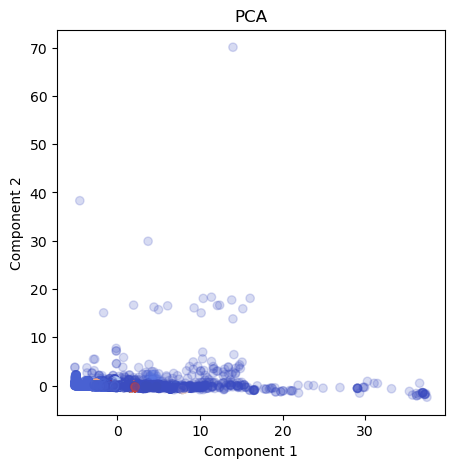

In [48]:
plt.figure(figsize=(5, 5))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=clusters, cmap='coolwarm',  alpha=0.2)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA')
plt.show()

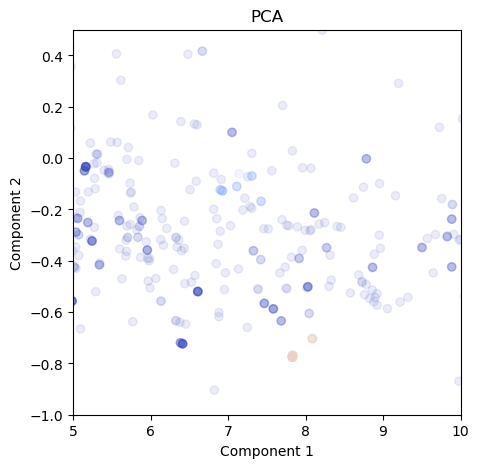

In [64]:


plt.figure(figsize=(5, 5))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=clusters, cmap='coolwarm',  alpha=0.1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA')
plt.xlim(5, 10)
plt.ylim(-1, 0.5)
plt.show()


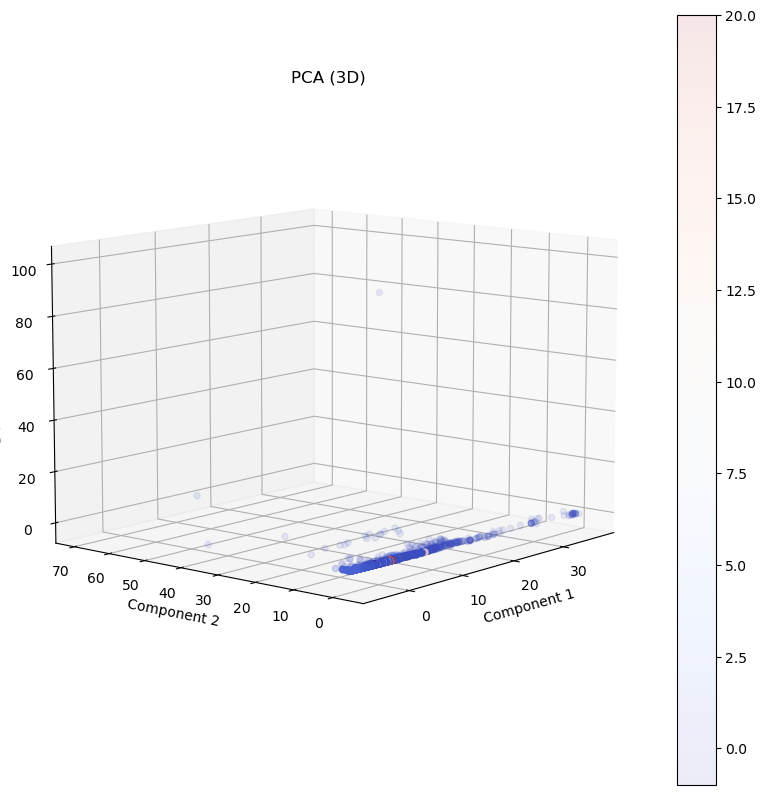

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(principalComponents3d[:, 0], principalComponents3d[:, 1], principalComponents3d[:, 2], c=clusters, cmap='coolwarm',  alpha=0.1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('PCA (3D)')

ax.view_init(10, 220)

fig.colorbar(scatter)

plt.show()

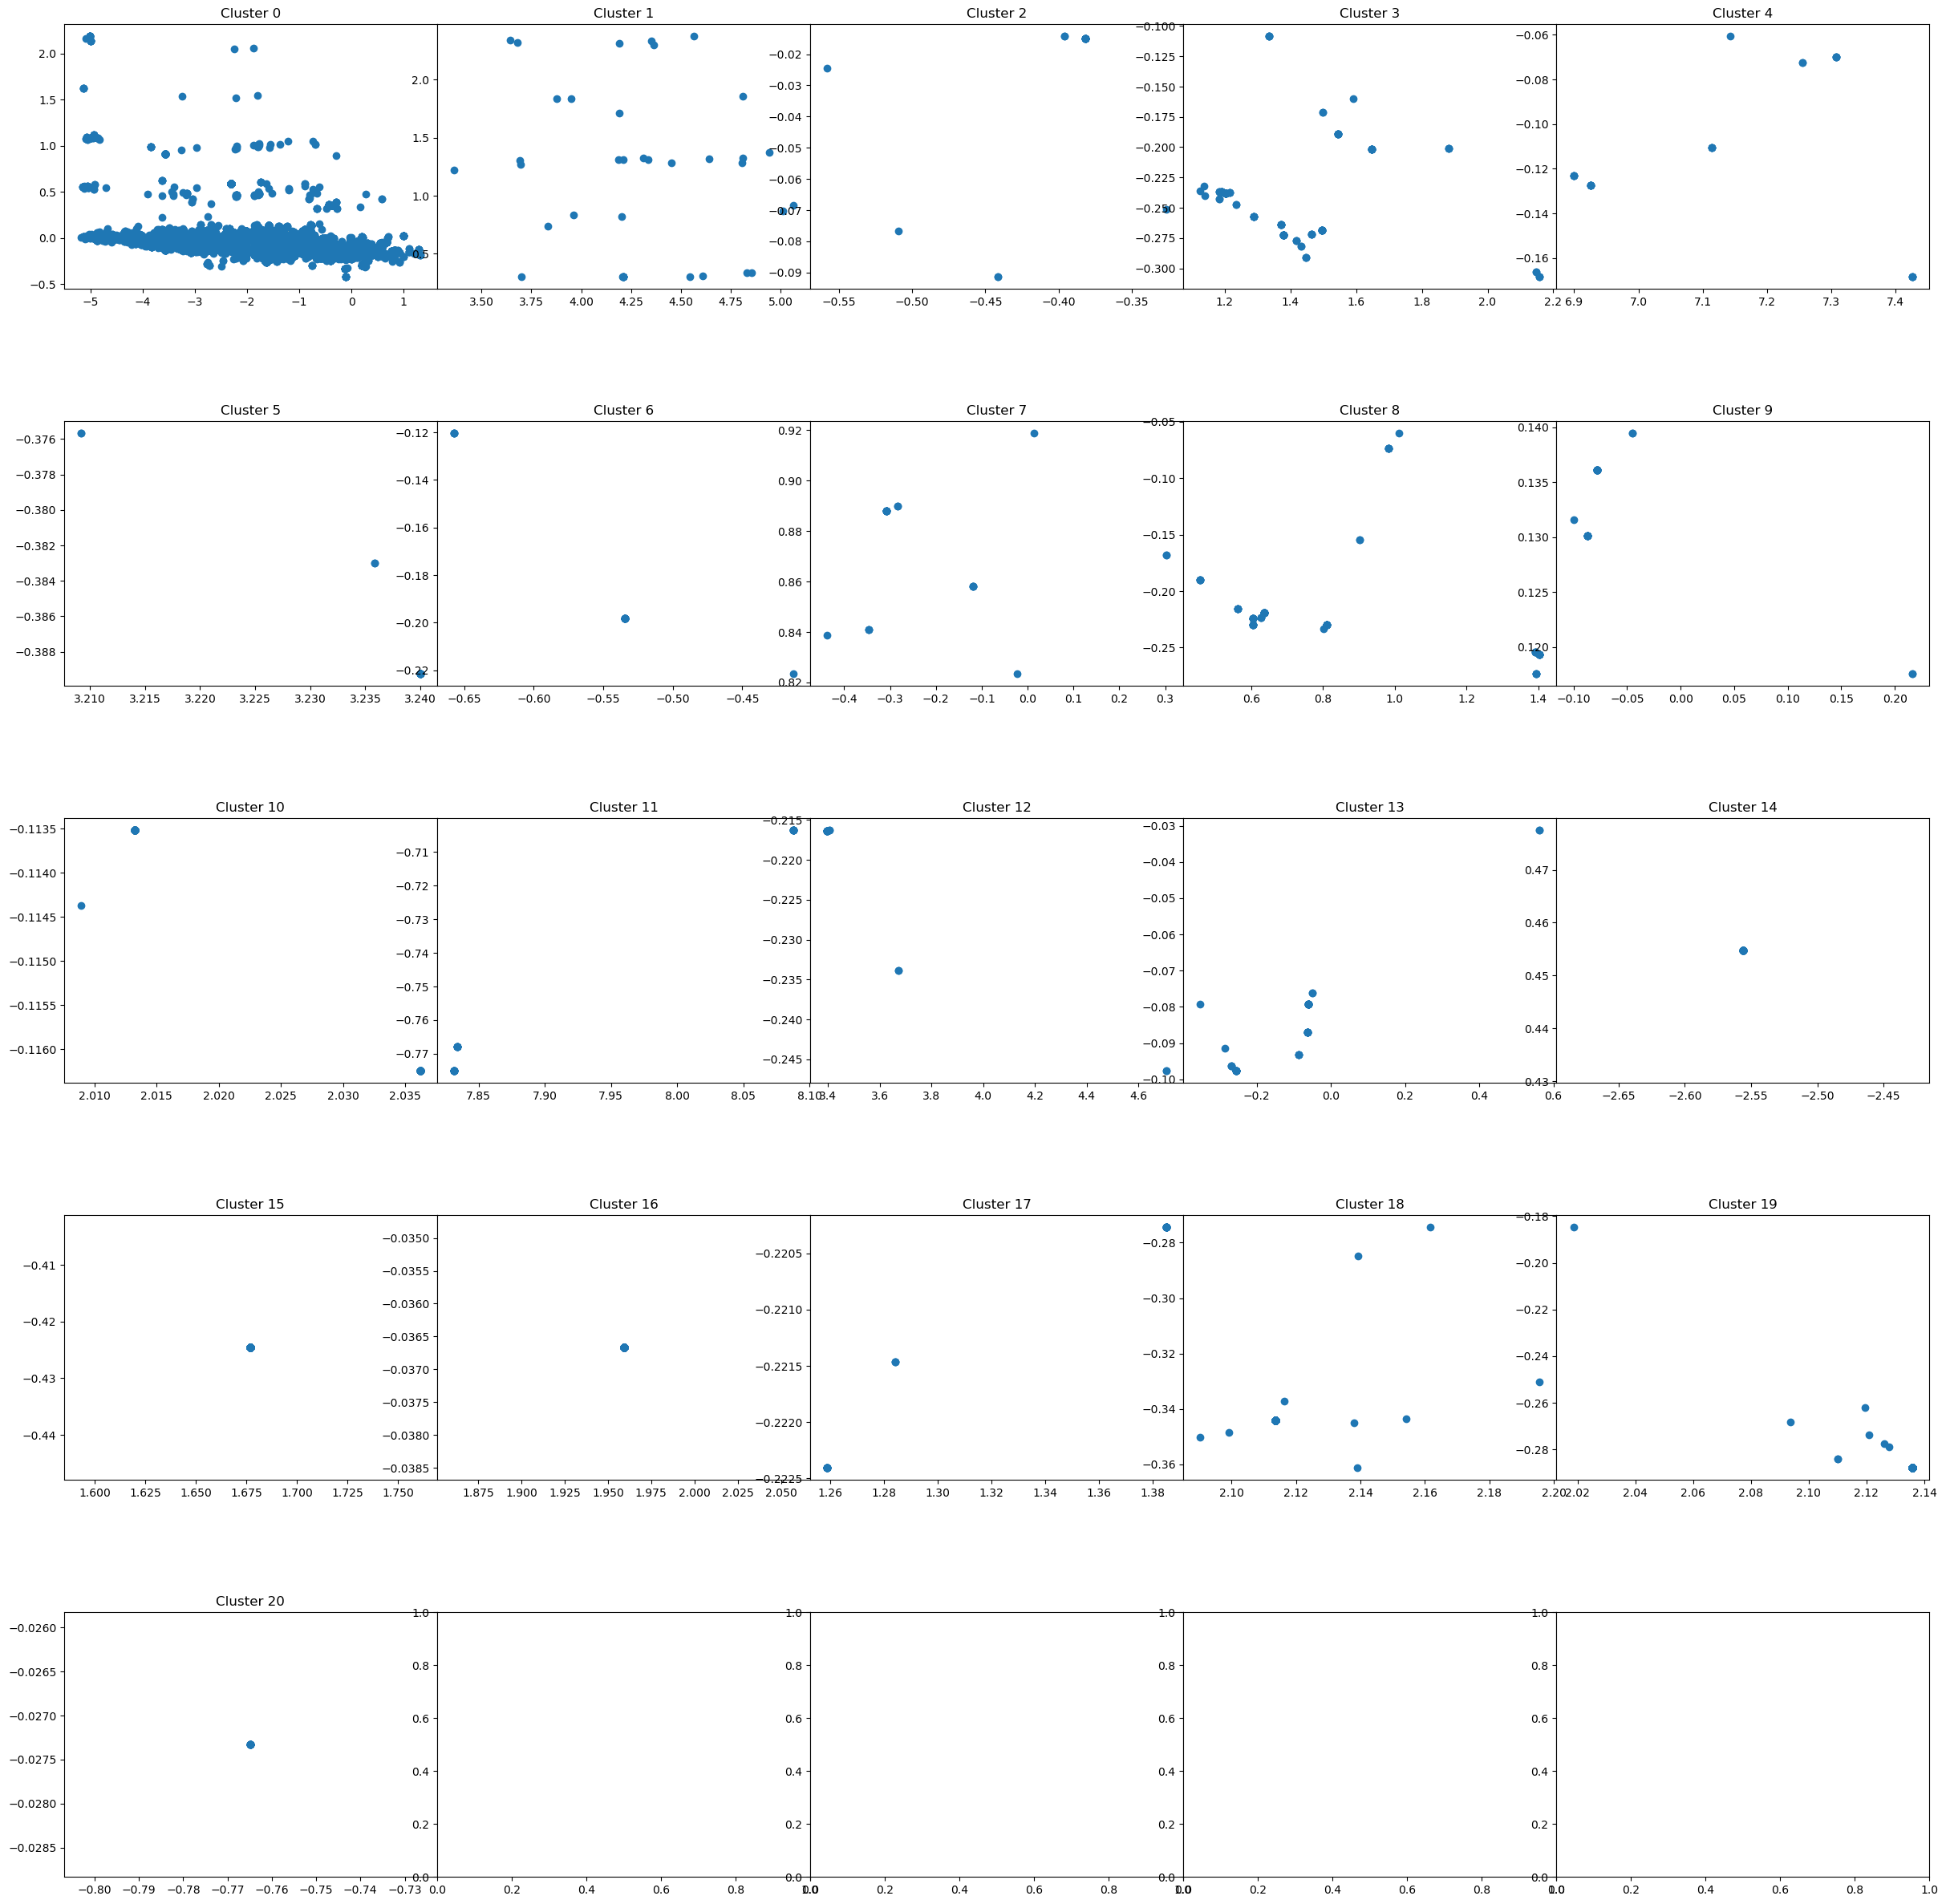

In [30]:
#hacer una grafica por cada cluster en 4 filas 5 columnas
fig, axs = plt.subplots(5, 5, figsize=(30, 30))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(num_clusters):
    cluster = df[df['cluster'] == i]
    axs[i].scatter(principalComponents[cluster.index, 0], principalComponents[cluster.index, 1])
    axs[i].set_title(f'Cluster {i}')

plt.show()

In [75]:
#imprimir dos secuencias del mismo cluster 
cluster = 17
df_cluster = df[df['cluster'] == cluster]
display(df_cluster.head()['sequence'])
display(df_cluster.tail()['sequence'])


7356    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
7362    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
7369    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
7376    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
7383    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
Name: sequence, dtype: object

8561    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
8562    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
8563    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
8564    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
8565    MNEVKESLRSIEQKYKLFQQQQLTFTAALEHCRENAHDKIRPISSI...
Name: sequence, dtype: object

### 3.2. K-means

In [43]:
X = np.array(df['vector'].tolist())

inertia = []
k_values = range(12, 400, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


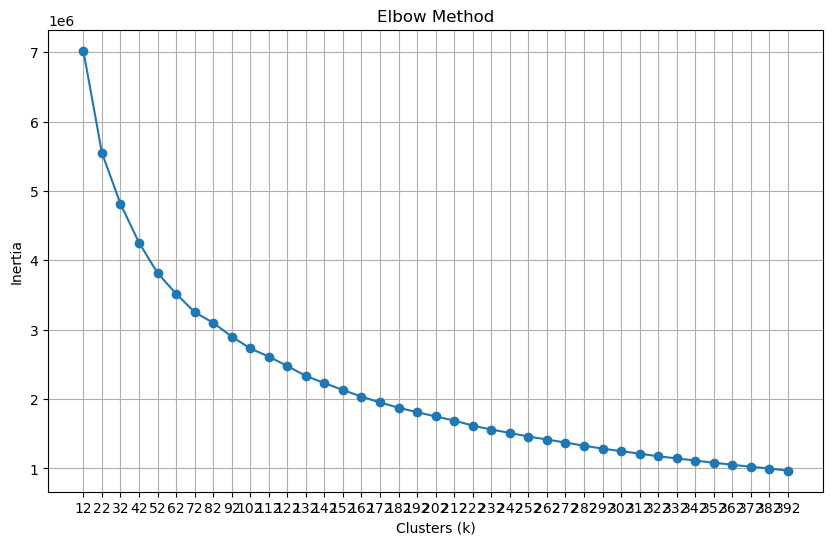

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

### 4. Analysis of results